In [1]:
!pip install torchvision wandb


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import time

import torch
import torchvision
from torchvision.transforms import ToTensor, Compose, PILToTensor
from einops import rearrange
from einops.layers.torch import Rearrange
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.datasets import CIFAR10, CIFAR100
import matplotlib.pyplot as plt

import wandb

from mamba_ssm.models.mixer_seq_simple import MambaConfig, MambaLMHeadModel

/home/james/github/jamesparsloe/notebooks/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset, n_classes = "cifar-10", 10
# dataset, n_classes = "cifar-100", 100

DatasetCls = CIFAR10 if dataset == "cifar-10" else CIFAR100

In [4]:
root = os.path.expanduser("~/.cache/torchvision")
os.makedirs(root, exist_ok=True)

train_ds = DatasetCls(root, train=True, download=True)
val_ds = DatasetCls(root, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
img, cls = next(iter(train_ds))

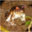

In [6]:
img

In [7]:
# NOTE: use PILToTensor to keep things as uint8, ToTensor will convert to float32 in [0.0, 1.0]
train_ds = DatasetCls(root, train=True, transform=PILToTensor(), download=True)
val_ds = DatasetCls(root, train=False, transform=PILToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
img, cls = next(iter(train_ds))

In [9]:
img.shape, img.dtype

(torch.Size([3, 32, 32]), torch.uint8)

In [10]:
train_ds = DatasetCls(
    root,
    train=True,
    transform=Compose([PILToTensor(), Rearrange("C H W -> H W C")]),
    download=True,
)

val_ds = DatasetCls(
    root,
    train=False,
    transform=Compose([PILToTensor(), Rearrange("C H W -> H W C")]),
    download=True,
)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
img, cls = next(iter(train_ds))

In [12]:
C, H, W = 3, 32, 32
n_classes = 10
rgb_offsets = 256 * torch.arange(C)

In [13]:
img

tensor([[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [14]:
img + rgb_offsets

tensor([[[ 59, 318, 575],
         [ 43, 302, 557],
         [ 50, 304, 555],
         ...,
         [158, 388, 620],
         [152, 381, 614],
         [148, 380, 615]],

        [[ 16, 276, 532],
         [  0, 256, 512],
         [ 18, 264, 512],
         ...,
         [123, 344, 567],
         [119, 339, 562],
         [122, 343, 569]],

        [[ 25, 280, 533],
         [ 16, 263, 512],
         [ 49, 283, 520],
         ...,
         [118, 340, 562],
         [120, 340, 562],
         [109, 329, 554]],

        ...,

        [[208, 426, 608],
         [201, 409, 546],
         [198, 417, 538],
         ...,
         [160, 389, 582],
         [ 56, 287, 519],
         [ 53, 290, 532]],

        [[180, 395, 608],
         [173, 379, 554],
         [186, 400, 542],
         ...,
         [184, 404, 606],
         [ 97, 318, 546],
         [ 83, 309, 546]],

        [[177, 400, 628],
         [168, 385, 606],
         [179, 398, 599],
         ...,
         [216, 440, 652],
        

In [15]:
def collate(items):
    batch = []
    for img, cls in items:
        token_ids = img + rgb_offsets # offset each of the rgb values - we'll share the Embedding
        token_ids = rearrange(token_ids, "H W C -> (H W C)")
        token_ids = token_ids + n_classes # offset by the number of classes
        token_ids = torch.cat((torch.tensor([cls]), token_ids)) # will embed the cls as the prefix
        batch.append(token_ids)
    return torch.stack(batch)

In [16]:
batch_size = 32

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate, drop_last=True)

In [17]:
next(iter(train_dl)), next(iter(val_dl))

(tensor([[  3,  98, 336,  ...,  31, 288, 549],
         [  8, 154, 415,  ...,  95, 346, 589],
         [  9, 178, 464,  ..., 204, 452, 683],
         ...,
         [  8, 263, 521,  ...,  69, 358, 621],
         [  5, 197, 461,  ..., 137, 401, 661],
         [  0, 154, 420,  ..., 140, 397, 583]]),
 tensor([[  3, 168, 378,  ...,  31, 333, 632],
         [  8, 245, 501,  ..., 196, 466, 721],
         [  8, 168, 456,  ...,  17, 274, 529],
         ...,
         [  6,  98, 395,  ...,  56, 320, 540],
         [  6,  67, 296,  ..., 125, 366, 591],
         [  5, 137, 396,  ..., 113, 372, 585]]))

In [18]:
def configure_optimizers(self, *, weight_decay, lr: float, betas: tuple[float, float]):
    # start with all of the candidate parameters
    param_dict = {pn: p for pn, p in self.named_parameters()}
    # filter out those that do not require grad
    param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
    # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
    # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
    decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
    nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
    optim_groups = [
        {"params": decay_params, "weight_decay": weight_decay},
        {"params": nodecay_params, "weight_decay": 0.0},
    ]
    num_decay_params = sum(p.numel() for p in decay_params)
    num_nodecay_params = sum(p.numel() for p in nodecay_params)
    print(
        f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters"
    )
    print(
        f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters"
    )
    # Create AdamW optimizer and use the fused version if it is available
    optimizer = torch.optim.AdamW(optim_groups, lr=lr, betas=betas, fused=True)

    return optimizer

In [19]:
vocab_size = n_classes + C * 256

lr = 3e-4

device = "cuda"

mamba_config = MambaConfig(
    d_model=512,
    n_layer=12,
    # d_model=768,
    # n_layer=24,
    vocab_size=vocab_size,
    ssm_cfg={},
    rms_norm=True,
    residual_in_fp32=True,
    fused_add_norm=True,
    pad_vocab_size_multiple=8,
)


model = MambaLMHeadModel(mamba_config).to(device)
optimizer = configure_optimizers(model, weight_decay=0.01, lr=lr, betas=(0.9, 0.95))

num decayed parameter tensors: 73, with 20,701,184 parameters
num non-decayed parameter tensors: 49, with 43,520 parameters


In [20]:
next(iter(val_dl))

tensor([[  3, 168, 378,  ...,  31, 333, 632],
        [  8, 245, 501,  ..., 196, 466, 721],
        [  8, 168, 456,  ...,  17, 274, 529],
        ...,
        [  6,  98, 395,  ...,  56, 320, 540],
        [  6,  67, 296,  ..., 125, 366, 591],
        [  5, 137, 396,  ..., 113, 372, 585]])

In [21]:
class_names = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

In [22]:
n_epochs = 10
log_every = 10
max_norm = 1.0

amp_dtype = (
    torch.bfloat16
)  # change to torch.float16 if your GPU doesn't support bfloat16

assert torch.cuda.is_bf16_supported()

scaler = torch.cuda.amp.GradScaler(enabled=amp_dtype == torch.float16)
n_parameters = sum(p.numel() for p in model.parameters()) / 1e6

print(f"{n_parameters}M parameters")


model.train()

losses = []
val_losses = []

step = 0

t1 = time.perf_counter()

for epoch in range(1, n_epochs + 1):
    for token_ids in train_dl:
        token_ids = token_ids.to(device, non_blocking=True)
        input_ids = token_ids[:, :-1].contiguous()
        target_ids = token_ids[:, 1:].contiguous()

        with torch.amp.autocast(dtype=amp_dtype, enabled=True, device_type="cuda"):
            output = model(input_ids)

            logits = output.logits

            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                target_ids.view(-1),
            )

        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()

        optimizer.zero_grad()
        losses.append(loss.item())

        step += 1

        if step % log_every == 0:
            t2 = time.perf_counter()
            throughput = log_every * batch_size / (t2 - t1)
            print(
                f"{step=} loss={loss.item():.3f} grad_norm={grad_norm.item():.3f} {throughput=:.2f} samples/s"
            )
            t1 = t2

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for token_ids in val_dl:
            token_ids = token_ids.to(device, non_blocking=True)
            input_ids = token_ids[:, :-1].contiguous()
            target_ids = token_ids[:, 1:].contiguous()

            with torch.amp.autocast(dtype=amp_dtype, enabled=True, device_type="cuda"):
                output = model(input_ids)

                logits = output.logits

                loss = F.cross_entropy(
                    logits.view(-1, logits.size(-1)),
                    target_ids.view(-1),
                )

                val_loss += loss.item()

    val_loss = val_loss / len(val_dl)

    val_losses.append(val_loss)

    print(f"End of epoch {epoch} val loss {val_loss:.3f}")

    model.eval()

    n = 6

    temperature = 1.0
    top_k = 64

    generation_batch_size = n * n

    # TODO doesn't like autocast here?
    with torch.inference_mode():
        input_ids = torch.randint(
            0,
            n_classes,
            (
                generation_batch_size,
                1,
            ),
            device=device,
        )
        out = model.generate(
            input_ids,
            max_length=1 + H * W * C,
            temperature=temperature,
            top_k=top_k,
            cg=True,
        )

    generated_ids = out[:, 1:]
    generated = rearrange(generated_ids, "B (H W C) -> B H W C", H=H, W=W, C=C)
    generated = generated.cpu()
    generated = generated - rgb_offsets - n_classes

    checkpoint_name = f"mamba-cifar-10-{int(n_parameters)}M-{epoch=}"

    fig, ax = plt.subplots(n, n, figsize=(16, 16))

    for i in range(n):
        for j in range(n):
            ax[i, j].imshow(generated[i * n + j])
            ax[i, j].axis("off")
            class_name = class_names[input_ids[i * n + j].item()]
            ax[i, j].set_title(class_name)

    fig.savefig(f"{checkpoint_name}.png")

    model.train()

    torch.save(model.state_dict(), f"{checkpoint_name}.pt")

20.744704M parameters
step=10 loss=5.828 grad_norm=0.919 throughput=39.60 samples/s
step=20 loss=4.912 grad_norm=0.737 throughput=88.10 samples/s
step=30 loss=4.298 grad_norm=0.834 throughput=88.12 samples/s
step=40 loss=3.986 grad_norm=0.659 throughput=88.10 samples/s
step=50 loss=3.847 grad_norm=1.313 throughput=88.10 samples/s
step=60 loss=3.672 grad_norm=1.880 throughput=88.12 samples/s
step=70 loss=3.627 grad_norm=1.356 throughput=88.11 samples/s
step=80 loss=3.652 grad_norm=1.181 throughput=88.11 samples/s
step=90 loss=3.439 grad_norm=1.234 throughput=88.07 samples/s
step=100 loss=3.452 grad_norm=1.621 throughput=88.00 samples/s
step=110 loss=3.458 grad_norm=1.858 throughput=88.00 samples/s
step=120 loss=3.480 grad_norm=1.736 throughput=88.01 samples/s
step=130 loss=3.333 grad_norm=1.147 throughput=88.02 samples/s
step=140 loss=3.448 grad_norm=1.461 throughput=88.03 samples/s
step=150 loss=3.304 grad_norm=0.989 throughput=88.01 samples/s
step=160 loss=3.274 grad_norm=1.786 throug

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step=1570 loss=2.983 grad_norm=0.693 throughput=8.79 samples/s
step=1580 loss=2.896 grad_norm=0.927 throughput=87.84 samples/s
step=1590 loss=2.804 grad_norm=0.845 throughput=87.85 samples/s
step=1600 loss=2.897 grad_norm=0.903 throughput=87.84 samples/s
step=1610 loss=3.093 grad_norm=0.787 throughput=87.84 samples/s
step=1620 loss=2.918 grad_norm=0.848 throughput=87.83 samples/s
step=1630 loss=2.874 grad_norm=0.810 throughput=87.84 samples/s
step=1640 loss=2.850 grad_norm=0.946 throughput=87.84 samples/s
step=1650 loss=2.887 grad_norm=0.734 throughput=87.84 samples/s
step=1660 loss=2.897 grad_norm=0.877 throughput=87.83 samples/s
step=1670 loss=2.936 grad_norm=0.710 throughput=87.85 samples/s
step=1680 loss=2.836 grad_norm=0.743 throughput=87.85 samples/s
step=1690 loss=2.748 grad_norm=0.792 throughput=87.84 samples/s
step=1700 loss=2.793 grad_norm=0.710 throughput=87.84 samples/s
step=1710 loss=2.909 grad_norm=0.706 throughput=87.86 samples/s
step=1720 loss=2.802 grad_norm=0.734 thro

In [ ]:
generated